# [Statoil/C-CORE Iceberg Classifier Challenge](https://www.kaggle.com/c/statoil-iceberg-classifier-challenge)
### Ship or iceberg, can you decide from space?

Here what this challenge is about, quoted from the Kaggle website:

*"Drifting icebergs present threats to navigation and activities in areas such as offshore of the East Coast of Canada.*

*Currently, many institutions and companies use aerial reconnaissance and shore-based support to monitor environmental conditions and assess risks from icebergs. However, in remote areas with particularly harsh weather, these methods are not feasible, and the only viable monitoring option is via satellite.*

*Statoil, an international energy company operating worldwide, has worked closely with companies like C-CORE. C-CORE have been using satellite data for over 30 years and have built a computer vision based surveillance system. To keep operations safe and efficient, Statoil is interested in getting a fresh new perspective on how to use machine learning to more accurately detect and discriminate against threatening icebergs as early as possible.*

*In this competition, you’re challenged to build an algorithm that automatically identifies if a remotely sensed target is a ship or iceberg. Improvements made will help drive the costs down for maintaining safe working conditions."*

I am fairly new to deep learning and this competition was a fantastic playground to try out a bunch of different approaches, technologies and frameworks. I have tested MXNet, Keras and PyTorch and I have to admit that the ease of use of the latter is just striking, hence I decided to go ahead and experiment entirely with this framework. Here the steps I have followed:

1. Preparing the dataset to be ingested into a Deep Net pipeline
2. Fine-tuning a pre-trained DensNet (a very deep CNN)
3. Repeating step 2 with data augmentation
4. Repeating step 2 with re-initialization of the learning rate every 6 epochs
5. Freezing the first 3 layers of the DensNet and re-training only the last 3
6. Using some data augmentaion on the test set as well. This basically means running the model on different versions of the same image and then averaging probabilities (i.e some sort of ensembling)

### Imports

In [1]:
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from sklearn.metrics import log_loss
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
%matplotlib inline
import time
import os
from PIL import Image
from scipy.optimize import minimize

plt.ion()   # interactive mode
from decimal import Decimal

### Helper Functions

In [2]:
def color_composite(data):
    """
    Transforming a pandas dataframe with 2 flattened 75x75 bands
    into a 3-channel-RGB-numpy.ndarray image.
    The third channel is calculated by the ratio of the first two.
    Code taken from https://www.kaggle.com/keremt/getting-color-composites
    """
    rgb_arrays = []
    for i, row in data.iterrows():
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 / band_2

        r = (band_1 + abs(band_1.min())) / np.max((band_1 + abs(band_1.min())))
        g = (band_2 + abs(band_2.min())) / np.max((band_2 + abs(band_2.min())))
        b = (band_3 + abs(band_3.min())) / np.max((band_3 + abs(band_3.min())))

        rgb = np.dstack((r, g, b))
        rgb_arrays.append(rgb)
    return np.array(rgb_arrays)

def imshow(inp, title=None):
    """
    Visualize a batch of data with labels
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig, ax = plt.subplots(figsize=(18, 3))
    ax.imshow(inp)
    plt.tight_layout()
    if title is not None:
        plt.title(title, fontdict={'fontsize': 20})
    plt.pause(0.001)  # pause a bit so that plots are updated
    
def train_model(model, criterion, optimizer, scheduler, path_to_save, restartlr=False, num_epochs=25):
    """
    Training a PyTorch model.
    Returning the model itself plus train/validation loss and learning rate VS epoch
    """
    since = time.time()
    train_loss = {}
    val_loss = {}
    lr_dict = {}

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                if restartlr:
                    if epoch % 6 == 0 and epoch != 0:
                        print('Resetting LR')
                        scheduler.step(epoch=-1)
                    else: scheduler.step()
                else: scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            if phase == 'train': 
                train_loss[epoch] = epoch_loss
                lr_dict[epoch] = optimizer.param_groups[0]['lr']
            else: val_loss[epoch] = epoch_loss
            
            print('{} Loss: {:.4f} Acc: {:.4f} LR: {:.2E}'.format(phase, epoch_loss, epoch_acc, Decimal(optimizer.param_groups[0]['lr'])))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                torch.save(model, path_to_save)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss, val_loss, lr_dict

## 1. Preparing the dataset
Quoted from Kaggle:

"The data (train.json, test.json) is presented in json format. The files consist of a list of images, and for each image, you can find the following fields:

* **id** - the id of the image
* **band_1, band_2** - the flattened image data. Each band has 75x75 pixel values in the list, so the list has 5625 elements. Note that these values are not the normal non-negative integers in image files since they have physical meanings - these are float numbers with unit being dB. Band 1 and Band 2 are signals characterized by radar backscatter produced from different polarizations at a particular incidence angle. The polarizations correspond to HH (transmit/receive horizontally) and HV (transmit horizontally and receive vertically). More background on the satellite imagery can be found here.
* **inc_angle** - the incidence angle of which the image was taken. Note that this field has missing data marked as "na", and those images with "na" incidence angles are all in the training data to prevent leakage.
* **is_iceberg** - the target variable, set to 1 if it is an iceberg, and 0 if it is a ship. This field only exists in train.json."

Given the structure of the data, I am going to transform the 2-bands images into more classic 3-channel-RGB pictures, as this is what most DL frameworks, especially pre-trained models, accept by default.

In [25]:
train = pd.read_json('./data/iceberg/train.json')
train.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


Checking class imbalance. Seems like we have a pretty balanced dataset. Some actual numbers later on.


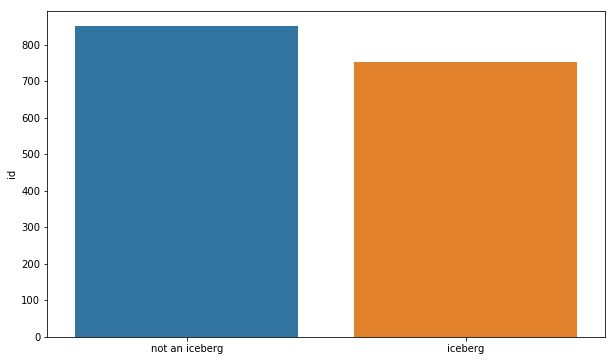

In [26]:
print('Checking class imbalance. Seems like we have a pretty balanced dataset. Some actual numbers later on.')

f,ax = plt.subplots(1,1,figsize=(10,6))
sns.barplot(x=['not an iceberg','iceberg'],y=train.groupby(['is_iceberg'],as_index=False).count()['id'])
plt.show()

Here we transform the original pandas dataframe into a numpy array containing 75x75x3 images

In [27]:
train_rgb = color_composite(train)

print(train_rgb.shape, type(train_rgb))

(1604, 75, 75, 3) <class 'numpy.ndarray'>


Splitting original dataset into train and validation set

In [28]:
X_train, X_validation, y_train, y_validation = train_test_split(train, train.is_iceberg, test_size = 0.2, random_state=42, stratify= train.is_iceberg)

In [29]:
print('Train shape:', X_train.shape)
print('Validation shape', X_validation.shape)
print('% of Icebergs in Train:', sum(X_train.is_iceberg)/X_train.shape[0])
print('% of Icebergs in Validation:', sum(X_validation.is_iceberg)/X_validation.shape[0])

Train shape: (1283, 5)
Validation shape (321, 5)
% of Icebergs in Train: 0.469212782541
% of Icebergs in Validation: 0.470404984424


Splitting Train and Validation into *yes_iceberg, no_iceberg* to easily access images and save them as JPGs into their specific folders

In [14]:
no_iceberg_t = X_train[X_train.is_iceberg == 0]
yes_iceberg_t = X_train[X_train.is_iceberg == 1]
no_iceberg_v = X_validation[X_validation.is_iceberg == 0]
yes_iceberg_v = X_validation[X_validation.is_iceberg == 1]

print(no_iceberg_t.shape, yes_iceberg_t.shape)
print(no_iceberg_v.shape, yes_iceberg_v.shape)

(681, 5) (602, 5)
(170, 5) (151, 5)


Saving numpy arrays as JPGs. Take a second to notice the folder structure.

*train* and *validation* are 2 separate directories split into 2 subdirectories containing icebergs and ships.

PyTorch is going to access these folders (in alphabetical order, so *no_iceberg* first and *yes_iceberg* second) and assign a label to the images, 1 for icebergs and 0 for ships.

In [16]:
no_path_t = './data/iceberg/pytorch_icebergs/train/no_iceberg/'
for idx in no_iceberg_t.index:
    img = train_rgb[idx]
    plt.imsave(no_path_t + train.iloc[idx, 2] + '.jpg', img)

yes_path_t = './data/iceberg/pytorch_icebergs/train/yes_iceberg/'
for idx in yes_iceberg_t.index:
    img = train_rgb[idx]
    plt.imsave(yes_path_t + train.iloc[idx, 2] + '.jpg', img)

In [17]:
no_path_v = './data/iceberg/pytorch_icebergs/val/no_iceberg/'
for idx in no_iceberg_v.index:
    img = train_rgb[idx]
    plt.imsave(no_path_v + train.iloc[idx, 2] + '.jpg', img)

yes_path_v = './data/iceberg/pytorch_icebergs/val/yes_iceberg/'
for idx in yes_iceberg_v.index:
    img = train_rgb[idx]
    plt.imsave(yes_path_v + train.iloc[idx, 2] + '.jpg', img)

Same treatment for test set too.

In [10]:
test = pd.read_json('./data/iceberg/test.json')
test.head()

,band_1,band_2,id,inc_angle
0,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",5941774d,34.966400
1,"[-26.058969497680664, -26.058969497680664, -26...","[-25.754207611083984, -25.754207611083984, -25...",4023181e,32.615072
2,"[-14.14109992980957, -15.064241409301758, -17....","[-14.74563980102539, -14.590410232543945, -14....",b20200e4,37.505433
3,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",e7f018bb,34.473900
4,"[-23.37459373474121, -26.02718162536621, -28.1...","[-25.72234344482422, -27.011577606201172, -23....",4371c8c3,43.918874


In [46]:
test_rgb = color_composite(test)

print(test_rgb.shape, type(test_rgb))

(8424, 75, 75, 3) <class 'numpy.ndarray'>


In [24]:
test_path = './data/iceberg/test_images/test/'
for idx in test.index:
    img = test_rgb[idx]
    plt.imsave(test_path + test.iloc[idx, 2] + '.jpg', img)

# Deep Learning Pipeline

A couple of clarifications here before getting started.

a. Why a **pre-trained** model? Quoting some [CNN notes](http://cs231n.github.io/transfer-learning/) from Stanford: "In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. [ImageNet](http://www.image-net.org/index), which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest." This whole thing is also called **transfer-learning**.

b. How does **transfer-learning** look like in practice? The idea here is that we re-use a pre-trained network and we adapt (finetune) it to our new task. There are two main transfer-learning scenarios. Again quoting Stanford: "**ConvNet as fixed feature extractor**. Take a ConvNet pretrained on ImageNet, remove the last fully-connected layer (this layer’s outputs are the 1000 class scores for a different task like ImageNet), then treat the rest of the ConvNet as a fixed feature extractor for the new dataset. In an AlexNet, this would compute a 4096-D vector for every image that contains the activations of the hidden layer immediately before the classifier. We call these features CNN codes. It is important for performance that these codes are ReLUd (i.e. thresholded at zero) if they were also thresholded during the training of the ConvNet on ImageNet (as is usually the case). Once you extract the 4096-D codes for all images, train a linear classifier (e.g. Linear SVM or Softmax classifier) for the new dataset. **Fine-tuning the ConvNet**. The second strategy is to not only replace and retrain the classifier on top of the ConvNet on the new dataset, but to also fine-tune the weights of the pretrained network by continuing the backpropagation. It is possible to fine-tune all the layers of the ConvNet, or it’s possible to keep some of the earlier layers fixed (due to overfitting concerns) and only fine-tune some higher-level portion of the network. This is motivated by the observation that the earlier features of a ConvNet contain more generic features (e.g. edge detectors or color blob detectors) that should be useful to many tasks, but later layers of the ConvNet becomes progressively more specific to the details of the classes contained in the original dataset. In case of ImageNet for example, which contains many dog breeds, a significant portion of the representational power of the ConvNet may be devoted to features that are specific to differentiating between dog breeds." We'll try both approaches and see which one works best and in which conditions.

c. What is a **DensNet** and why this one specifically? Let's start from the why. Because I have tried all the other available pre-trained architectures (take a look [here](http://pytorch.org/docs/master/torchvision/models.html)) and this one works the best. As for what a DensNet is, the best way to find out is to go through the original paper ["Densely Connected Convolutional Networks"](https://arxiv.org/pdf/1608.06993.pdf). In a nutshell, quoting the article, "Whereas traditional convolutional networks with L layers have L
connections—one between each layer and its subsequent layer, our network has L(L+1)/2 direct connections. For each layer, the feature-maps of all preceding layers are used as inputs, and its own feature-maps are used as inputs into all subsequent layers. [...] As CNNs become increasingly deep, a new research problem emerges: as information about the input or gradient passes through many layers, it can vanish and “wash out” by the time it reaches the end (or beginning) of the network. Many recent publications address this or related problems. [...]  Although these different approaches vary in network topology and training procedure, they all share a key characteristic: they create short paths from early layers to later layers."

Btw, below you can see how a DensNet looks like.

Quite deep indeed!

In [68]:
DensNet = models.densenet121(pretrained=True)
DensNet

DenseNet(
  (features): Sequential(
    (conv0): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm.1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu.1): ReLU(inplace)
        (conv.1): Conv2d (64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm.2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
        (relu.2): ReLU(inplace)
        (conv.2): Conv2d (128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm.1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
        (relu.1): ReLU(inplace)
        (conv.1): Conv2d (96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
     

## 2. Fine-tuning a pre-trained DensNet without Data Augmentation

This is the simplest of the solutions to implement. We just load the pre-trained DensNet and we re-train it on our raw data.
As we'll see from both accuracy levels during training and from the learning curves, we are clearly overfitting (as expected, due to the small dataset size).

Something to note is the fact that we adjust the learning rate during training, reducing it by 1/10 every 6 epochs. It is important to keep this in mind as we are going to play around with the learning rate later on.

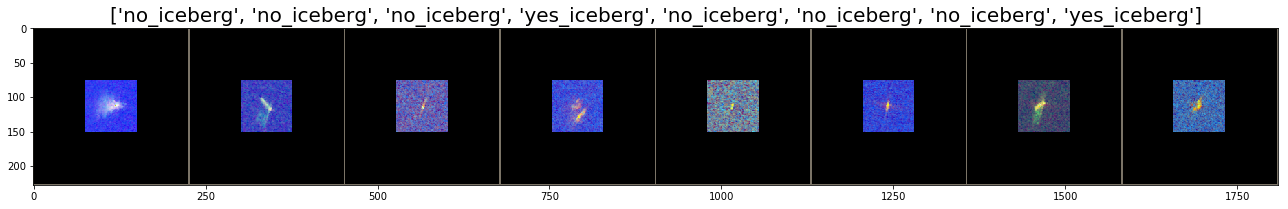

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ]),
}

data_dir = './data/iceberg/pytorch_icebergs'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [4]:
model_ft4 = models.densenet121(pretrained=True)
num_ftrs = model_ft4.classifier.in_features
model_ft4.classifier = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft4 = model_ft4.cuda()

criterion = nn.CrossEntropyLoss()

optimizer_ft4 = optim.SGD(model_ft4.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler4 = lr_scheduler.StepLR(optimizer_ft4, step_size=6, gamma=0.1)

In [5]:
model_ft4, train_loss, val_loss, lr_dict = train_model(model_ft4, criterion, optimizer_ft4, 
                                                       exp_lr_scheduler4, path_to_save='./densnet_noaug.pth' ,num_epochs=24)

Epoch 0/23
----------
train Loss: 0.0637 Acc: 0.7475 LR: 1.00E-3
val Loss: 0.0474 Acc: 0.8442 LR: 1.00E-3
Epoch 1/23
----------
train Loss: 0.0627 Acc: 0.7654 LR: 1.00E-3
val Loss: 0.0348 Acc: 0.8723 LR: 1.00E-3
Epoch 2/23
----------
train Loss: 0.0462 Acc: 0.8309 LR: 1.00E-3
val Loss: 0.0371 Acc: 0.8723 LR: 1.00E-3
Epoch 3/23
----------
train Loss: 0.0365 Acc: 0.8839 LR: 1.00E-3
val Loss: 0.0319 Acc: 0.8847 LR: 1.00E-3
Epoch 4/23
----------
train Loss: 0.0366 Acc: 0.8730 LR: 1.00E-3
val Loss: 0.0553 Acc: 0.7850 LR: 1.00E-3
Epoch 5/23
----------
train Loss: 0.0367 Acc: 0.8776 LR: 1.00E-3
val Loss: 0.0300 Acc: 0.8847 LR: 1.00E-3
Epoch 6/23
----------
train Loss: 0.0198 Acc: 0.9447 LR: 1.00E-4
val Loss: 0.0253 Acc: 0.9065 LR: 1.00E-4
Epoch 7/23
----------
train Loss: 0.0135 Acc: 0.9665 LR: 1.00E-4
val Loss: 0.0266 Acc: 0.9065 LR: 1.00E-4
Epoch 8/23
----------
train Loss: 0.0096 Acc: 0.9774 LR: 1.00E-4
val Loss: 0.0267 Acc: 0.9003 LR: 1.00E-4
Epoch 9/23
----------
train Loss: 0.0104 Acc: 

There is a huge delta between training and validation loss during training, with the latter being significantly higher that the former.
That's a clear overftting scenario


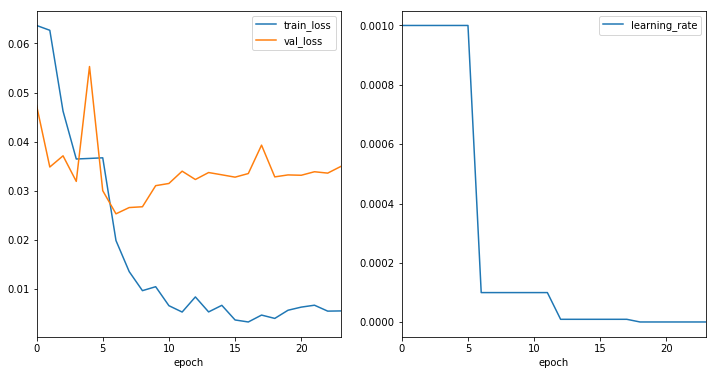

In [6]:
print('There is a huge delta between training and validation loss during training, with the latter being significantly higher that the former.')
print("That's a clear overftting scenario")

tl = pd.DataFrame.from_dict(train_loss, orient='index').reset_index()
tl.columns = ['epoch', 'train_loss']
vl = pd.DataFrame.from_dict(val_loss, orient='index').reset_index()
vl.columns = ['epoch', 'val_loss']
l = pd.DataFrame.from_dict(lr_dict, orient='index').reset_index()
l.columns = ['epoch', 'learning_rate']

tl = tl.merge(vl, on='epoch')

f, (ax1, ax2) = plt.subplots(1, 2)
tl.plot(x='epoch', y=['train_loss', 'val_loss'], ax=ax1)
l.plot(x='epoch', y='learning_rate', figsize=(12,6), ax=ax2)

## 3. Fine-tuning a pre-trained DensNet with Data Augmentation (to combat overfitting)

A nice and clean way to fight overfitting is to perform augmentations on raw images.

The idea is that, as we have few data inputs, we are going to artificially create more, applying random transformations (resizing, cropping, flipping, rotating) to them. We basically feed the network images which are always slightly different, epoch after epoch, hence we don't let the model "remember" pictures and eventually we manage to reduce variance.

The approach works very well indeed. We get to ~90% validation accuracy, but most importantly the learning curves look much better. There is almost no gap between training and validatrion loss.

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(180),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(180),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ]),
}

data_dir = './data/iceberg/pytorch_icebergs'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

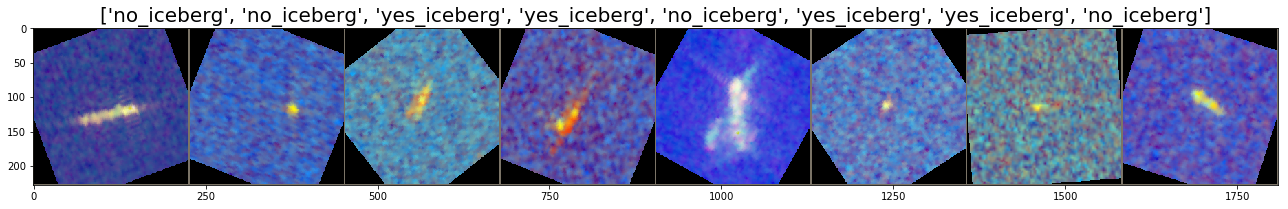

In [8]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [9]:
model_ft1 = models.densenet121(pretrained=True)
num_ftrs = model_ft1.classifier.in_features
model_ft1.classifier = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft1 = model_ft1.cuda()

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft1.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=6, gamma=0.1)

In [10]:
model_ft1, train_loss, val_loss, lr_dict = train_model(model_ft1, criterion, optimizer_ft, 
                                                       exp_lr_scheduler, path_to_save='./densnet.pth' ,num_epochs=24)

Epoch 0/23
----------
train Loss: 0.0722 Acc: 0.6929 LR: 1.00E-3
val Loss: 0.0499 Acc: 0.8162 LR: 1.00E-3
Epoch 1/23
----------
train Loss: 0.0561 Acc: 0.8067 LR: 1.00E-3
val Loss: 0.0411 Acc: 0.8442 LR: 1.00E-3
Epoch 2/23
----------
train Loss: 0.0537 Acc: 0.7973 LR: 1.00E-3
val Loss: 0.0404 Acc: 0.8536 LR: 1.00E-3
Epoch 3/23
----------
train Loss: 0.0563 Acc: 0.7935 LR: 1.00E-3
val Loss: 0.0483 Acc: 0.8442 LR: 1.00E-3
Epoch 4/23
----------
train Loss: 0.0455 Acc: 0.8418 LR: 1.00E-3
val Loss: 0.0375 Acc: 0.8816 LR: 1.00E-3
Epoch 5/23
----------
train Loss: 0.0489 Acc: 0.8316 LR: 1.00E-3
val Loss: 0.0572 Acc: 0.7882 LR: 1.00E-3
Epoch 6/23
----------
train Loss: 0.0371 Acc: 0.8745 LR: 1.00E-4
val Loss: 0.0372 Acc: 0.8692 LR: 1.00E-4
Epoch 7/23
----------
train Loss: 0.0348 Acc: 0.8722 LR: 1.00E-4
val Loss: 0.0316 Acc: 0.8910 LR: 1.00E-4
Epoch 8/23
----------
train Loss: 0.0353 Acc: 0.8769 LR: 1.00E-4
val Loss: 0.0309 Acc: 0.8972 LR: 1.00E-4
Epoch 9/23
----------
train Loss: 0.0355 Acc: 

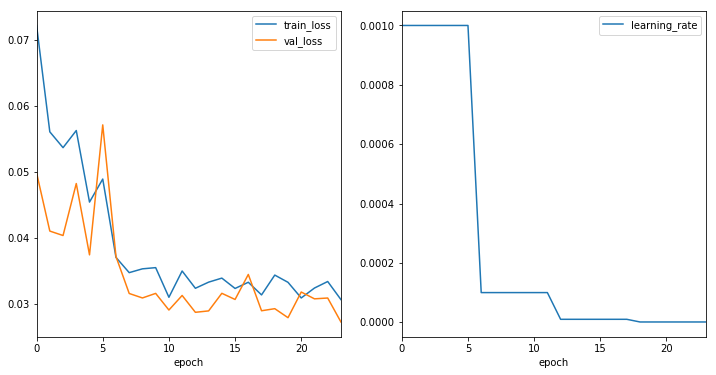

In [11]:
tl = pd.DataFrame.from_dict(train_loss, orient='index').reset_index()
tl.columns = ['epoch', 'train_loss']
vl = pd.DataFrame.from_dict(val_loss, orient='index').reset_index()
vl.columns = ['epoch', 'val_loss']
l = pd.DataFrame.from_dict(lr_dict, orient='index').reset_index()
l.columns = ['epoch', 'learning_rate']

tl = tl.merge(vl, on='epoch')

f, (ax1, ax2) = plt.subplots(1, 2)
tl.plot(x='epoch', y=['train_loss', 'val_loss'], ax=ax1)
l.plot(x='epoch', y='learning_rate', figsize=(12,6), ax=ax2)

## 4. Fine-tuning a pre-trained DensNet with Data Augmentation and Learning Rate Restart

The Learning Rate is probably the most important hyper-parameter within a DeepNet optimization. Its magnitude determines the way SGD explores the parameters space. Ideally we would start with a high LR to quickly move close to a local minimum in the loss function and, as the training progresses, we would slowly lower it down to smoothly approach the actual minimum.

The issue with this approch is that it assumes the inherent convexity of the parameters space, whereas it is more realistic to picture the loss surface as having multiple "holes". Ideally we would like to explore as much as possible within this space. Periodically increasing the learning rate lets us achieve just that. Phrased it differently, this trick pushes SGD out of a local minimum to start the exploration again out of it, with the hope to find a better place, i.e. with a lower loss value.

Take a look at the learning rate plot versus epochs. It is pretty clear what the trend is and how it impacts the loss.

In [12]:
model_ft2 = models.densenet121(pretrained=True)
num_ftrs = model_ft2.classifier.in_features
model_ft2.classifier = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft2 = model_ft2.cuda()

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft2.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=1, gamma=0.25)

In [13]:
model_ft2, train_loss, val_loss, lr_dict = train_model(model_ft2, criterion, optimizer_ft, exp_lr_scheduler, 
                                                       path_to_save='./densnet_restartlr.pth', restartlr=True, num_epochs=35)

Epoch 0/34
----------
train Loss: 0.0764 Acc: 0.6742 LR: 1.00E-3
val Loss: 0.0550 Acc: 0.8006 LR: 1.00E-3
Epoch 1/34
----------
train Loss: 0.0535 Acc: 0.7989 LR: 2.50E-4
val Loss: 0.0445 Acc: 0.8349 LR: 2.50E-4
Epoch 2/34
----------
train Loss: 0.0496 Acc: 0.8106 LR: 6.25E-5
val Loss: 0.0374 Acc: 0.8723 LR: 6.25E-5
Epoch 3/34
----------
train Loss: 0.0489 Acc: 0.8192 LR: 1.56E-5
val Loss: 0.0428 Acc: 0.8505 LR: 1.56E-5
Epoch 4/34
----------
train Loss: 0.0491 Acc: 0.8129 LR: 3.91E-6
val Loss: 0.0434 Acc: 0.8349 LR: 3.91E-6
Epoch 5/34
----------
train Loss: 0.0480 Acc: 0.8262 LR: 9.77E-7
val Loss: 0.0416 Acc: 0.8411 LR: 9.77E-7
Epoch 6/34
----------
Resetting LR
train Loss: 0.1193 Acc: 0.6812 LR: 4.00E-3
val Loss: 0.2616 Acc: 0.6168 LR: 4.00E-3
Epoch 7/34
----------
train Loss: 0.0669 Acc: 0.7467 LR: 1.00E-3
val Loss: 0.0503 Acc: 0.8037 LR: 1.00E-3
Epoch 8/34
----------
train Loss: 0.0532 Acc: 0.8036 LR: 2.50E-4
val Loss: 0.0442 Acc: 0.8380 LR: 2.50E-4
Epoch 9/34
----------
train Loss:

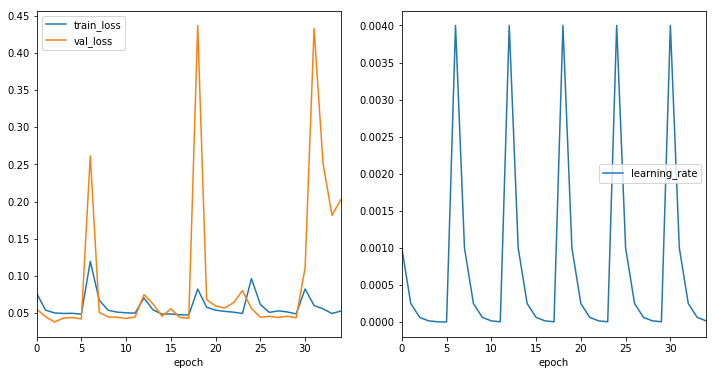

In [14]:
tl = pd.DataFrame.from_dict(train_loss, orient='index').reset_index()
tl.columns = ['epoch', 'train_loss']
vl = pd.DataFrame.from_dict(val_loss, orient='index').reset_index()
vl.columns = ['epoch', 'val_loss']
l = pd.DataFrame.from_dict(lr_dict, orient='index').reset_index()
l.columns = ['epoch', 'learning_rate']

tl = tl.merge(vl, on='epoch')

f, (ax1, ax2) = plt.subplots(1, 2)
tl.plot(x='epoch', y=['train_loss', 'val_loss'], ax=ax1)
l.plot(x='epoch', y='learning_rate', figsize=(12,6), ax=ax2)

## 5. Using the DensNet as an (almost) fixed feature extractor

This is the first transfer-learning scenario mentioned in the Stanford notes.
The principle is that we don't want to disrupt the pre-trained model re-training it from scratch on our dataset. We need to keep in mind that the weights have already been carefully tuned and so it is maybe advisable not to touch them at all, as we have instead done so far. An alternative approach consists in freezing at least the first layers and re-train only the last ones. In all honesty I don't think this is a good idea for this specific problem, reason being that the ImageNet dataset looks very different than the one we are currently working with. Features learned on cats, dogs, cars etc have likely almost nothing in common with satellite images of ships and icebergs, hence just initializing the net with pre-trained weights and then tweaking them sounds a much more reasonable approach.

As you'll see this is actually the case, so the fixed feature extractor path does not really work great.

Important note: please notice that we are not completely freezing the first layers. We are actually applying to them a very low learning rate, basically allwoing the weights to slowly change epoch after epoch. The end result is, in any case, very similar to not re-train the at all.

In [15]:
model_ft3 = models.densenet121(pretrained=True)
for param in [par for par in model_ft3.features.conv0.parameters()] +\
             [par for par in model_ft3.features.denseblock1.parameters()] + \
             [par for par in model_ft3.features.denseblock2.parameters()]:
    param.requires_grad = False
    
num_ftrs = model_ft3.classifier.in_features
model_ft3.classifier = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft3 = model_ft3.cuda()

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD([{'params': model_ft3.features.denseblock3.parameters(), 'lr': 1e-5},
                        {'params': model_ft3.features.denseblock4.parameters(), 'lr': 1e-4},
                        {'params': model_ft3.classifier.parameters(), 'lr': 1e-2}], lr=1e-3, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.8)

In [16]:
model_ft3, train_loss, val_loss, lr_dict = train_model(model_ft3, criterion, optimizer_ft, exp_lr_scheduler,
                                                      path_to_save='./densnet_freeze.pth' ,num_epochs=30)

Epoch 0/29
----------
train Loss: 0.2283 Acc: 0.6306 LR: 1.00E-5
val Loss: 0.1223 Acc: 0.7009 LR: 1.00E-5
Epoch 1/29
----------
train Loss: 0.2457 Acc: 0.7101 LR: 1.00E-5
val Loss: 0.1334 Acc: 0.7850 LR: 1.00E-5
Epoch 2/29
----------
train Loss: 0.2144 Acc: 0.7132 LR: 8.00E-6
val Loss: 0.1824 Acc: 0.7227 LR: 8.00E-6
Epoch 3/29
----------
train Loss: 0.1551 Acc: 0.7412 LR: 8.00E-6
val Loss: 0.1035 Acc: 0.7882 LR: 8.00E-6
Epoch 4/29
----------
train Loss: 0.1819 Acc: 0.7217 LR: 6.40E-6
val Loss: 0.1758 Acc: 0.7508 LR: 6.40E-6
Epoch 5/29
----------
train Loss: 0.1480 Acc: 0.7592 LR: 6.40E-6
val Loss: 0.0693 Acc: 0.8287 LR: 6.40E-6
Epoch 6/29
----------
train Loss: 0.1117 Acc: 0.7810 LR: 5.12E-6
val Loss: 0.0967 Acc: 0.7975 LR: 5.12E-6
Epoch 7/29
----------
train Loss: 0.1018 Acc: 0.7677 LR: 5.12E-6
val Loss: 0.1464 Acc: 0.6947 LR: 5.12E-6
Epoch 8/29
----------
train Loss: 0.1350 Acc: 0.7241 LR: 4.10E-6
val Loss: 0.1359 Acc: 0.7352 LR: 4.10E-6
Epoch 9/29
----------
train Loss: 0.1070 Acc: 

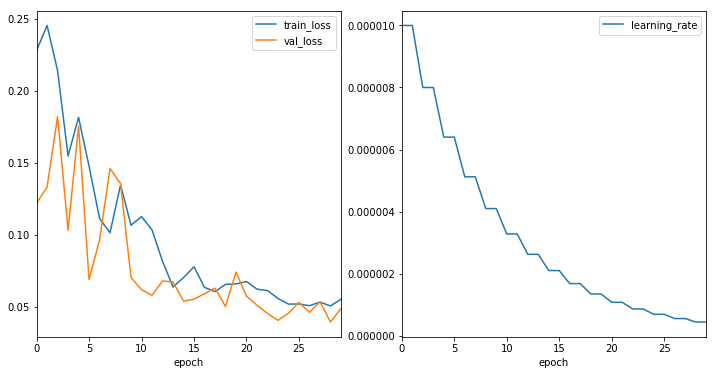

In [17]:
tl = pd.DataFrame.from_dict(train_loss, orient='index').reset_index()
tl.columns = ['epoch', 'train_loss']
vl = pd.DataFrame.from_dict(val_loss, orient='index').reset_index()
vl.columns = ['epoch', 'val_loss']
l = pd.DataFrame.from_dict(lr_dict, orient='index').reset_index()
l.columns = ['epoch', 'learning_rate']

tl = tl.merge(vl, on='epoch')

f, (ax1, ax2) = plt.subplots(1, 2)
tl.plot(x='epoch', y=['train_loss', 'val_loss'], ax=ax1)
l.plot(x='epoch', y='learning_rate', figsize=(12,6), ax=ax2)

## 6. Data Augmentation on the test set, i.e. ensembling DensNet probabilities

Ok, we have explored some basic possibilities to solve our iceberg challenge. To close the loop we have to generate a submission to Kaggle, i.e. we have to run our model on the test set.

We could simply apply the re-trained deep net on unseen images but a better idea to make our predictions more robust is to iterate over the test set several times transforming each image each time. Phrased differently we are going to perform data augmentation on the test set. The principle behind this idea is that every time the model sees a slightly modified version of the same picture it is going to spit out a slightly different probability of it being an iceberg. Averaging out these probabilities will reduce noise and hopefully stabilize the prediction as well, furtherly reducing loss.

In [19]:
test_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(180),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ])

path = './data/iceberg/test_images/test/'
images = {f.replace('.jpg', ''): os.path.join(path, f) for f in os.listdir(path) if 'jpg' in f}

In [20]:
model_ft = torch.load('./densnet.pth')
soft = nn.Softmax()
densnet_dict = {}

for i in range(5):
    for k, im in images.items():
        image = test_transforms(Image.open(im).convert('RGB')).unsqueeze(0)
        d = model_ft(Variable(image.cuda()))
        if i == 0:
            densnet_dict[k] = [soft(d).data.cpu().numpy().flatten()[1]]
        else: 
            densnet_dict[k].append(soft(d).data.cpu().numpy().flatten()[1])

/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.
/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


In [21]:
densnet_dict['007f8195']

[0.45910439, 0.52070016, 0.61964869, 0.42500347, 0.55482155]

In [22]:
dd = {k: np.mean(v) for k, v in densnet_dict.items()}
print(dd['007f8195'])

0.515856


In [23]:
denset_kaggle = pd.DataFrame.from_dict(dd, orient='index').reset_index()
denset_kaggle.columns = ['id', 'is_iceberg']
denset_kaggle.to_csv('./data/iceberg/for_kaggle.csv', index=False)
denset_kaggle.head(10)

,id,is_iceberg
0,4557372f,0.218215
1,2c9d1b48,0.033464
2,1ee45ac5,0.070717
3,156bd669,0.993827
4,567612b1,0.960779
5,f0d55d48,0.156331
6,fa530b08,0.017454
7,c48b752b,0.131932
8,b69eefe4,0.258191
9,0b2918c3,0.893857
